In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import enum
import itertools
import operator
import collections
import math
import codecs
from scipy import stats

%matplotlib inline

TODO explain why we chose HR=2, R=1, N=0 

In [2]:
@enum.unique
class Grade(enum.IntEnum):
    """
    Represents relevance on a graded scale. 
    Any positive number represents relevance, with higher numbers representing higher relevance (total ordering)
    Zero represents irrelevant
    """
    N = (0)   # Not relevant
    R = (1)   # Relevant
    HR = (2)  # Highly relevant

    
    @property
    def is_relevant(self):
        """
        'Binarizes' the relevance. Useful for computing binary metrics like precision / recall
        """
        return False if self.value == 0 else True
    
    @classmethod
    def from_int_list(cls, int_list):
        """
        Converts a list of integers to a list of Grade
        """
        members = dict((member.value, member) for member in cls.__members__.values())
        return [members[value] for value in int_list]

    @classmethod
    def max_grade(cls):
        return max(member.value for member in cls.__members__.values())

    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name

## Step 1: Simulate Rankings of Relevance for E and P (5 points)

In the first step you will generate pairs of rankings of relevance, for the production P and experimental E, respectively, for a hypothetical query q. Assume a 3-graded relevance, i.e. {N, R, HR}. Construct all possible P and E ranking pairs of length 5. This step should give you about.

Example:

P: {N N N N N}
E: {N N N N R}

…
P: {HR HR HR HR R}
E: {HR HR HR HR HR}

In [3]:
def get_all_permutations(grade, sequence_length):
    """
    For a given grade and a sequence length n, returns all possible permutations of length n that can be formed. 
    Note that a generator is returned and not a list
    """
    for i, perm in enumerate(itertools.product(range(len(grade.__members__)), repeat=sequence_length)):
        yield grade.from_int_list(perm)

def get_all_permutation_pairs(grade, sequence_length):
    """
    Generates all possible pairs of permutations given a grade and a sequence length.
    Note that a generator is returned and not a list
    """
    sequence_1 = get_all_permutations(grade, sequence_length)
    sequence_2 = get_all_permutations(grade, sequence_length)    
    for pair in itertools.product(sequence_1, sequence_2):
        yield pair
        
def count_sequence(seq):
    """
    `len` for generators
    """
    count = 0
    for _ in seq:
        count += 1
    return count

# A sanity check to ensure the correct number of sequences are being generated
# the `-(3**5)` removes exact duplicates
assert count_sequence(get_all_permutation_pairs(Grade, 5)) == (3**5) * (3**5)

TODO add assumption that we weed out exactly similar documents (or do WE?) dun dun dun

In [4]:
permutations = np.array(list(get_all_permutation_pairs(Grade, 5)), dtype=np.object)

In [5]:
permutations

array([[[N, N, N, N, N],
        [N, N, N, N, N]],

       [[N, N, N, N, N],
        [N, N, N, N, R]],

       [[N, N, N, N, N],
        [N, N, N, N, HR]],

       ..., 
       [[HR, HR, HR, HR, HR],
        [HR, HR, HR, HR, N]],

       [[HR, HR, HR, HR, HR],
        [HR, HR, HR, HR, R]],

       [[HR, HR, HR, HR, HR],
        [HR, HR, HR, HR, HR]]], dtype=object)

In [6]:
permutations[0]

array([[N, N, N, N, N],
       [N, N, N, N, N]], dtype=object)

In [7]:
permutations[-1]

array([[HR, HR, HR, HR, HR],
       [HR, HR, HR, HR, HR]], dtype=object)

In [8]:
production = np.array(list(map(operator.itemgetter(0), permutations)))
experiment = np.array(list(map(operator.itemgetter(1), permutations)))

TODO explain this in detail. It's one of the central assumptions we make. 
Single Query Assumption.
We can assume that the entire experiment is for a single query, so there are only 10 R + 10 HR documents i.e a total of 20 relevant documents.

Comment by Ece: Isn't this already given in the description along with the idea that the returned documents will be unique? Our assumption was more in the line of supposing that there are 10 irrelevant documents in the collection, given query q.

In [9]:
# TODO double check this
relevant_count_production = 20
relevant_count_experiment = 20
(relevant_count_experiment, relevant_count_production)

(20, 20)

## Step 2: Implement Evaluation Measures (10 points)
Implement 1 binary and 2 multi-graded evaluation measures out of the 7 measures mentioned above. 

In [10]:
class Metric:
    
    """
    Common parent for all metrics
    """
    
    def name(self):
        raise NotImplementedError()
    
    def compute(self, results, **kwargs):
        """ TODO """
        raise NotImplementedError()

class Precision(Metric):
    """
    TODO
    """
    @property
    def name(self):
        return "precision"
    
    def compute(self, results, **kwargs):
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(results))
        
        # only up to k
        results = results[:k]
        # binarize, compute how many are relevant and divide by k
        return sum(r.is_relevant for r in results) / k
    
class Recall(Metric):
    """ TODO """
    @property
    def name(self):
        return "recall"
    
    def compute(self, results, **kwargs):
        assert "relevant_count" in kwargs
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(production))
        
        # only up to k
        results = results[:k]
        # binarize and count, divide by number of relevant documents
        # the number of relevant documents is a function of the total number of relevant documents
        # and how many *can* be present in a list of length k
        # if there are only k = 5 and total = 20, recall can never be 1 even when the all documents are relevant
        # therefore, the denom should be min(k, total)
        # TODO verify
        return sum(r.is_relevant for r in results) / kwargs["relevant_count"] 
        
    
class AveragePrecision(Metric):
    """ TODO """
    
    def compute(self, results, **kwargs):
        assert "relevant_count" in kwargs
        P = Precision()
        precisions = np.zeros(len(results))
        for k in range(1, len(results) + 1):
            if(str(results[k-1]) != 'N'):
                precisions[k - 1] = P.compute(results, k = k)
        # TODO verify
        return precisions.sum() / kwargs["relevant_count"] 

AP = AveragePrecision()
ap = np.array([AP.compute(r, relevant_count = relevant_count_production) for r in production])
print(ap)

[ 0.    0.    0.   ...,  0.25  0.25  0.25]


In [11]:
ap.mean()

0.13648148148148148

In [12]:
ap.max()

0.25

TODO Explain why the max in our case can only be 25, so this shit is right!

Comment by Ece: I think the calculation of average precision only considers precision values at ranks where relevant documents are returned, does the method above take it into consideration? I might be missing something, but it seems to me that it adds up all the precision values. JUST ADDED THE IF STATEMENT 

(array([ 1701.,  4374.,  6318.,  6804.,  6804.,  9720.,  3888.,  7776.,
         3888.,  7776.]),
 array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
         0.2  ,  0.225,  0.25 ]),
 <a list of 10 Patch objects>)

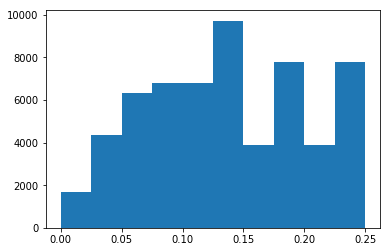

In [13]:
plt.hist(ap)

In [14]:
class DCG(Metric):
    """ TODO """
    
    def compute(self, results, **kwargs):
        
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(production))
        
        # only up to k
        results = results[:k]
        
        dcg = 0.0 
        for rank, result in enumerate(results):
            rank += 1 # TODO verify
            gain = 2**result.value - 1
            discount = math.log2(1 + rank)
            dcg += gain / discount
        return dcg


class NDCG(Metric):
    """ TODO """

    # NDCG: We considered two possibilities. TODO explain it
    # Normalization is done according to the slides mentioned here 
    # https://web.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    def compute(self, results, **kwargs):
        assert "ideal_ranking" in kwargs
        
        dcg = DCG()
        
        ideal_ranking = kwargs["ideal_ranking"]
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(results))
        
        # only up to k
        results = results[:k]
        ideal_ranking = ideal_ranking[:k]
        
        max_dcg = dcg.compute(ideal_ranking)
        
        return NDCG.dcg.compute(results) / max_dcg

ideal_ranking = [Grade.HR] * 10 + [Grade.R] * 10 + [Grade.N] * 10
print(ideal_ranking)

[HR, HR, HR, HR, HR, HR, HR, HR, HR, HR, R, R, R, R, R, R, R, R, R, R, N, N, N, N, N, N, N, N, N, N]


In [15]:
class ERR(Metric):
    # TODO cite this http://delivery.acm.org/10.1145/1650000/1646033/p621-chapelle.pdf?ip=145.109.35.88&id=1646033&acc=ACTIVE%20SERVICE&key=0C390721DC3021FF%2E86041C471C98F6DA%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&CFID=1026312371&CFTOKEN=18042814&__acm__=1515748872_543fbe0fe6a5c9d1fadb8f8341c9da3c
    # TODO and explain how you converted to code
    def compute(self, results, **kwargs):
        assert "grade" in kwargs
        grade = kwargs["grade"]
        
        def r_func(result):
            return ((2 ** result.value) - 1) / (2 ** grade.max_grade())  
        
        err = 0.0
        for rank, result in enumerate(results):
            previous_results = results[:rank]
            satisfaction = 1
            for previous_result in previous_results:
                satisfaction = satisfaction * ((1 - r_func(previous_result)))
            # rank is 0-indexed here, so add 1
            # I am not sure, but I think r_func(result) should be here. Please check TODO
            err += (1/(rank + 1)) * satisfaction * r_func(result)
            print(err)
        return err
# TODO this is incorrect. I couldn't figure out what is going wrong

# Comment by Ece: The part where you multiply with r_func(result) seems correct, when compared to slides by Ilya.
# I failed to see how this is incorrect, could you explain why?
# https://lingpipe-blog.com/2010/03/09/chapelle-metzler-zhang-grinspan-2009-expected-reciprocal-rank-for-graded-relevance/
# http://don-metzler.net/presentations/err_cikm09.pdf

err = ERR()
print(err.compute([Grade.HR, Grade.HR, Grade.HR, Grade.HR], grade=Grade))
print(err.compute([Grade.N, Grade.N, Grade.N, Grade.HR], grade=Grade))

0.75
0.84375
0.859375
0.8623046875
0.8623046875
0.0
0.0
0.0
0.1875
0.1875


## Step 3: Calculate the 𝛥measure (0 points)

For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.

In [16]:
average_precision = AveragePrecision()
ndcg = NDCG() # TODO or pick ERR?

# TODO which measure do we use to subset? All 3 or just one? right now I"m doing only one

average_precision_P = np.array([average_precision.compute(results, relevant_count = relevant_count_production) \
                                for results in production])
average_precision_E = np.array([average_precision.compute(results, relevant_count = relevant_count_experiment) \
                                for results in experiment])
delta_measure = average_precision_E - average_precision_P
len(permutations[delta_measure > 0])

27954

In [17]:
permutations = permutations[delta_measure > 0]
production = production[delta_measure > 0]
experiment = experiment[delta_measure > 0]

## Step 4: Implement Interleaving (15 points)
Implement 2 interleaving algorithms: 
(1) Team-Draft Interleaving OR Balanced Interleaving, ~~AND (2), Probabilistic Interleaving.~~ 

The interleaving algorithms should (a) given two rankings of relevance interleave them into a single ranking, and (b) given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

In [18]:
def toss_coin(heads = 0.5):
    # head = True, Tails is False
    return True if random.random() < heads else False

TODO explain

Citations for both algorithms: 

https://www.cs.cornell.edu/people/tj/publications/radlinski_etal_08b.pdf

https://www.cs.cornell.edu/people/tj/publications/chapelle_etal_12a.pdf


In [19]:
Interleaved = collections.namedtuple("Interleaved", ["source", "source_index", "result"])
        
class BalancedInterleaving:
    
    @staticmethod
    def interleave(A, B, A_name, B_name):

        selected = toss_coin()
        interleaved = []
        
        ka = 0
        kb = 0
        
        while(ka <= len(A) and kb <= len(B) and (ka < len(A) or kb < len(B))):

            if (ka < kb) or (ka==kb and selected):
                    tup = Interleaved(A_name, ka, A[ka])
                    # assumption: all docs are unique, most recently picked document is not in the interleaved list
                    interleaved.append(tup)
                    ka += 1

            else:  
                    tup = Interleaved(B_name, kb, B[kb])
                    # assumption: all docs are unique, most recently picked document is not in the interleaved list
                    interleaved.append(tup)
                    kb += 1
        
        return interleaved
    
    @staticmethod
    def score_clicks(interleaved, clicks):
        scores = collections.defaultdict(int)
        
        #assumption: all docs are unique, just count the clicks belonging to each algorithm

        for c in clicks:
            il = interleaved[c]
            scores[il.source] += 1
            
        return scores
    
A = [Grade.R, Grade.HR, Grade.N]
B = [Grade.R, Grade.N, Grade.HR]

interleaved = BalancedInterleaving.interleave(A, B, "A", "B")
interleaved

[Interleaved(source='A', source_index=0, result=R),
 Interleaved(source='B', source_index=0, result=R),
 Interleaved(source='A', source_index=1, result=HR),
 Interleaved(source='B', source_index=1, result=N),
 Interleaved(source='A', source_index=2, result=N),
 Interleaved(source='B', source_index=2, result=HR)]

In [20]:
clicks = [0, 2, 4]
BalancedInterleaving.score_clicks(interleaved, clicks)

defaultdict(int, {'A': 3})

In [94]:
class TeamDraftInterleaving:
    """ TODO """
    
    @staticmethod
    def interleave(A, B, A_name, B_name):

        interleaved = []
        TeamA = set()
        TeamB = set()

        ka = 0
        kb = 0

        while(ka <= len(A) and kb <= len(B)):
            selected = toss_coin()
            if ka == len(A) and kb == len(B):
                break
            elif(len(TeamA) < len(TeamB)) or (len(TeamA) == len(TeamB) and selected == 0):
                tup = Interleaved(A_name, ka, A[ka])
                interleaved.append(tup)
                TeamA.add(tup)
                ka += 1
            else:
                tup = Interleaved(B_name, kb, B[kb])
                interleaved.append(tup)
                TeamB.add(tup)
                kb +=1
               
        return interleaved

    @staticmethod
    def score_clicks(interleaved, clicks):
        scores = collections.defaultdict(int)
        
        for c in clicks:
            il = interleaved[c]
            scores[il.source] += 1
            
        return scores
                
A = [Grade.R, Grade.HR, Grade.N]
B = [Grade.R, Grade.N, Grade.HR]

interleaved = TeamDraftInterleaving.interleave(A, B, "A", "B")
interleaved

[Interleaved(source='A', source_index=0, result=R),
 Interleaved(source='B', source_index=0, result=R),
 Interleaved(source='B', source_index=1, result=N),
 Interleaved(source='A', source_index=1, result=HR),
 Interleaved(source='B', source_index=2, result=HR),
 Interleaved(source='A', source_index=2, result=N)]

In [22]:
ClickAction = collections.namedtuple("ClickAction", ["clicked_id"])
QueryAction = collections.namedtuple("QueryAction", ["query_id", "results"])

class Session:
    def __init__(self, session_id):
        self.session_id = session_id
        self.data = []
    
    @property
    def clicks(self):
        return list(filter(lambda _: isinstance(_, ClickAction), self.data))
    
    @property
    def queries(self):
        return list(filter(lambda _: isinstance(_, QueryAction), self.data))
    
    def get_complete_interactions(self):
        # return complete interactions
        last_query = 0
        for index, action in enumerate(self.data):
            if index != 0 and isinstance(action, QueryAction):
                yield self.data[last_query: index]
                last_query = index
        if isinstance(self.data[-1], ClickAction):
            yield self.data[last_query:]
        
class YandexData:
    def __init__(self, file_path):
        self.file_path = file_path
        self.sessions = []
        self.u = 0
        self.q = 0
        self._read()
        
    def _read(self):
        with codecs.open(self.file_path, "r", "utf-8") as reader:
            current_session = Session(0)
            for line in reader:
                line = line.split("\t")
                session_id = int(line[0])
                interaction_type = line[2]
                if current_session.session_id != session_id:
                    self.sessions.append(current_session)
                    current_session = Session(session_id)
                
                if interaction_type == "C":
                    current_session.data.append(ClickAction(int(line[3])))
                else:
                    results = [int(q_id) for q_id in line[5:]]
                    self.u = max(self.u, max(results))
                    query_id = int(line[3])
                    self.q = max(self.q, query_id)
                    current_session.data.append(QueryAction(query_id, results))
        
        self.sessions.append(current_session)


yandex_data = YandexData("./YandexRelPredChallenge.txt")
print("Total number of sessions: ", len(yandex_data.sessions))
print("Total number of interactions: ", sum(len(session.data) for session in yandex_data.sessions))

Total number of sessions:  11717
Total number of interactions:  100000


In [23]:
class RandomClickModel:
    def __init__(self):
        self.rho = 0
    
    def estimate(self, yandex_data):
        clicks = 0
        results = 0
        for session in yandex_data.sessions:
            clicks += len(session.clicks)
            results += sum(len(query.results) for query in session.queries)
        self.rho = clicks / results
    
    def predict(self, clicks):
        #(b) there is a method that predicts the click probability given a ranked list of relevance labels,
        pass
    
    @staticmethod
    def simulate(results, grade_to_probability, params):
        rho = params.get("rho")
        assert 0 <= rho <= 1.0
        
        # TODO something is wrong with this and I can't figure it out. pls fix 
        clicks = []
        for rank, result in enumerate(results):
            click = toss_coin(rho)
            if click:
                clicks.append(rank)
        return clicks

rcm = RandomClickModel()
rcm.estimate(yandex_data)
rcm.rho

0.13445559411047547

In [24]:
yandex_data.u, yandex_data.q

(527494, 66579)

In [25]:
class SimpleDynamicBayesianNetwork:
        
    def _estimate_sigma(self, yandex_data):
        satisfied_clicks = collections.defaultdict(lambda : collections.defaultdict(float))
        total_clicks = collections.defaultdict(lambda : collections.defaultdict(float))
        
        
        for session in yandex_data.sessions:
            for interaction in session.get_complete_interactions():
                #print(interaction) TODO explain why we continue
                if not isinstance(interaction[-1], ClickAction):
                    continue
                query_action = interaction[0]
                # sanity check TODO remove
                assert isinstance(query_action, QueryAction)
                for click in interaction[1:]:
                    # sanity check TODO remove
                    assert isinstance(click, ClickAction)
                    total_clicks[click.clicked_id][query_action.query_id] += 1
                
                last_click = interaction[-1]
                #print(last_click)
                satisfied_clicks[last_click.clicked_id][query_action.query_id] += 1
        
        self.sigma = collections.defaultdict(lambda : collections.defaultdict(float))
        
        all_clicks = 0
        all_satisfied = 0
        for click_id, queries in total_clicks.items():
            for query_id, count in queries.items():
                self.sigma[click_id][query_id] = satisfied_clicks[click_id][query_id] / count
                all_clicks += count
                all_satisfied += satisfied_clicks[click_id][query_id]
        
        self.sigma_global = all_satisfied / all_clicks
                
    def _estimate_alpha(self, yandex_data):
        seen = collections.defaultdict(lambda : collections.defaultdict(float))
        clicks = collections.defaultdict(lambda : collections.defaultdict(float))
        
        for session in yandex_data.sessions:
            for interaction in session.get_complete_interactions():
                query_action = interaction[0]
                assert isinstance(query_action, QueryAction)
                
                for result in query_action.results:
                    seen[result][query_action.query_id] += 1
                
                for click in interaction[1:]:
                    # sanity check TODO remove
                    assert isinstance(click, ClickAction)
                    clicks[click.clicked_id][query_action.query_id] += 1
                

        
        self.alpha = collections.defaultdict(lambda : collections.defaultdict(float))
        for click_id, queries in seen.items():
            for query_id, count in queries.items():
                self.alpha[click_id][query_id] = clicks[click_id][query_id] / count
    
    
    def estimate(self, yandex_data):
        self._estimate_sigma(yandex_data)
        self._estimate_alpha(yandex_data)
        
    @staticmethod
    def simulate(results, grade_to_probability, params):
        clicks = []
        for index, result in enumerate(results):
            examine = toss_coin(grade_to_probability[result])
            if not examine:
                continue
            clicks.append(index)
            
            satisfied = toss_coin(grade_to_probability[result])
            if satisfied:
                break
                
        return clicks


In [26]:

# TODO compute one sigma from all of it
    
# TODO replace with how you compute alpha
grade_to_probability = {
    Grade.N: 0.1,
    Grade.R: 0.5,
    Grade.HR: 0.9
}
    
sdbn = SimpleDynamicBayesianNetwork()
sdbn.estimate(yandex_data)
sdbn.sigma_global

0.5121189928157913

In [27]:
def simulate(interleaving, click_model, params):
    winner_E = 0
    ties = 0
    for production, experimental in permutations:
        interleaved = interleaving.interleave(production, experimental, "P", "E")
        clicks = click_model.simulate([i.result for i in interleaved], grade_to_probability, params)
        scores = interleaving.score_clicks(interleaved, clicks)
        
        if scores["E"] > scores["P"]:
            winner_E += 1
        elif scores["E"] == scores["P"]:
            ties += 1

    return (winner_E / (len(permutations) - ties))

In [28]:
len(permutations)

27954

In [29]:
# TODO permutations Consider only those pairs for which E outperforms P.


In [30]:
simulate(TeamDraftInterleaving, RandomClickModel, {"rho": rcm.rho})

0.49633796214917675

In [31]:
simulate(TeamDraftInterleaving, SimpleDynamicBayesianNetwork, {})

0.6224135143873262

In [32]:
simulate(BalancedInterleaving, RandomClickModel, {"rho": rcm.rho})

0.49894859813084114

In [3]:
simulate(TeamDraftInterleaving, SimpleDynamicBayesianNetwork, {})

NameError: name 'simulate' is not defined

In [ ]:
#t-test, used central limit theorem. Create 30 samples by simulating 30 times for each condition 
# and compare. Since the data is parametric we can use t-tests

sim_teamdraft_RCM = []
sim_teamdraft_SDBM = []
sim_interleaved_RCM = []
sim_interleaved_SDBM = []


for i in range(30):
    sim_teamdraft_RCM.append(simulate(TeamDraftInterleaving, RandomClickModel, {"rho": rcm.rho}))
    sim_teamdraft_SDBM.append(simulate(TeamDraftInterleaving, SimpleDynamicBayesianNetwork, {}))
    sim_interleaved_RCM.append(simulate(BalancedInterleaving, RandomClickModel, {"rho": rcm.rho}))
    sim_interleaved_SDBM.append(simulate(BalancedInterleaving, SimpleDynamicBayesianNetwork, {}))

In [ ]:
# creating the sign test (uses data of 1 trial only since non-parametric)

def sign_test(interleaving, click_model, params):

    sign_array = []
    for production, experimental in permutations:
        interleaved = interleaving.interleave(production, experimental, "P", "E")
        clicks = click_model.simulate([i.result for i in interleaved], grade_to_probability, params)
        scores = interleaving.score_clicks(interleaved, clicks)
        sign_array.append(scores["E"] - scores["P"])
    z, p = stats.wilcoxon(sign_array)
    return z, p

In [ ]:
# compares using t-test 2 sample (comparing with RCM, which is equal to chance)

z, p = stats.ttest_ind(sim_teamdraft_RCM,sim_teamdraft_SDBM)
print("P-value = {}".format(p))

z, p = stats.ttest_ind(sim_interleaved_RCM,sim_interleaved_SDBM)
print("P-value = {}".format(p))

# using a one sample t-test (comparing with 0.5 i.e. chance)

z, p = stats.ttest_1samp(sim_interleaved_SDBM, 0.5)
print("P-value = {}".format(p))

z, p = stats.ttest_1samp(sim_interleaved_SDBM, 0.5)
print("P-value = {}".format(p))


# using the non-parametric sign tests to compare.

z, p = sign_test(TeamDraftInterleaving, RandomClickModel, {"rho": rcm.rho})
print("P-value = {}".format(p))

z, p = sign_test(TeamDraftInterleaving, SimpleDynamicBayesianNetwork, {})
print("P-value = {}".format(p))

z, p = sign_test(BalancedInterleaving, RandomClickModel, {"rho": rcm.rho})
print("P-value = {}".format(p))

z, p = sign_test(BalancedInterleaving, SimpleDynamicBayesianNetwork, {})
print("P-value = {}".format(p))

# Theoretical Part

## 1.a

Type I error occurs when a hypothesis test rejects $H_0$ indicating significance, where in reality this should not be the case. The probability of Type I error is as follows:
P($H_0$ is rejected | $H_0$ is true) = $\alpha$

Hence, in order to obtain the probability asked in this question, we multiply the probability of not making a Type I error in the first m-1 cases and making this error at the $m^{th}$ case.

P($m^{th}$ experiment gives significant result | m experiments lacking power to reject $H_0$) = $(1-\alpha)^{m-1}\alpha$

## 1.b
We calculate the probability of at least one significant result in the presence of experiments that cannot reject the null hypothesis as indicated below, subtracting the probability of not making a Type I error at all from 1.

P(at least one significant result | m experiments lacking power to reject $H_0$) = 1 - $(1-\alpha)^m$



## 2
Both balanced interleaving and team-draft interleaving do not take the similarity of the lists into consideration. In cases where the ranks of the documents retrieved by two different search algorithms are similar, the comparison based on clicks given interleaved lists might be biased [Hofmann et al. 2011, 2013]. If the documents are swapped or their ranks are shifted by one level, team-draft interleaving might fail to capture the difference between the two algorithms. 

Similar to the examples given in Hofmann et al. [2011, 2013], we can consider 2 lists $l_1$ and $l_2$, both retrieving $d_1$, $d_2$ and $d_3$ in similar rankings such as: $l_1 = [d_1,d_2,d_3]$ and $l_2 = [d_2,d_3,d_1]$. If we take $d_3$ as the relevant document and assume that the one and only click occur on $d_3$, we expect that the score of $l_2$ output by the interleaving function should be higher than $l_1$'s score. The reason for this is that $l_2$ places the relevant document in the higher levels. 

When we construct possible interleaved lists, we observe that $d_3$ is placed at the 3rd rank in all of these lists.

<img src="interleaving.png">

When the clicks are on $d_3$, both lists will acquire the same score of 2. This will result in a tie and the actual difference between the qualities of the algorithms will be overlooked ($l_2$ being better than $l_1$).

In addition, ambiguous queries can lead to biased outcomes in team-draft interleaving where the rankings are shifted by one as indicated in [Chapelle et al. 2012].

Chapelle, O., Joachims, T., Radlinski, F., and Yue,Y. Large scale validation and analysis of interleaved search evaluation. ACM Transactions on Information Science, 30(1), 2012.

Hofmann, K., Whiteson, S., and de Rijke, M. A probabilistic method for inferring preferences from clicks. In
CIKM ’11, pp. 249–258, USA, 2011. ACM.

Hofmann, Katja, Whiteson, Shimon, and de Rijke, Maarten. Fidelity, soundness, and efficiency of interleaved
comparison methods. ACM Transactions on Information Systems, 31(4), 2013.

